In [1]:
import geopandas as gpd
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pypalettes import load_cmap
import matplotlib.patches as mpatches
import matplotlib.patheffects as path_effects
import matplotlib.colors as mcolors

In [2]:
url = "https://raw.githubusercontent.com/JosephBARBIERDARNAL/data-matplotlib-journey/refs/heads/main/accident-london/accident-london.csv"
df = pd.read_csv(url)

In [3]:
df.head(2)

,id,Longitude,Latitude,severity,n_vehicles,year
0,200901BS70001,-0.201349,51.512273,2,2,2009
1,200901BS70002,-0.199248,51.514399,2,2,2009


In [4]:
url = "https://raw.githubusercontent.com/JosephBARBIERDARNAL/data-matplotlib-journey/refs/heads/main/london/london.geojson"
gdf = gpd.read_file(url)

In [5]:
gdf.head(2)

,name,geometry
0,Barking and Dagenham,"POLYGON ((0.18859 51.55387, 0.18831 51.55402, ..."
1,Barnet,"POLYGON ((-0.28515 51.63711, -0.28516 51.6371,..."


In [6]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [7]:
gdf = gdf.set_index("name")

In [8]:
gdf["centroid"] = gdf.centroid

/tmp/ipykernel_180373/1929852611.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["centroid"] = gdf.centroid


In [9]:
df_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs="EPSG:4326")

In [10]:
df_joined = gpd.sjoin(df_gdf, gdf)

In [11]:
df_grouped = df_joined.groupby("name")["id"].size().reset_index(name="total_count")

In [12]:
df_grouped= pd.merge(df_grouped, gdf, on="name")

In [13]:
df_grouped = gpd.GeoDataFrame(df_grouped, crs="EPSG:4326")

In [14]:
df_grouped["name"] = df_grouped["name"].replace({"Barking and Dagenham": "Barking and\nDagenham", "Waltham Forest": "Waltham\nForest"})

In [15]:
boroughs_text = df_grouped["name"].unique()

In [16]:
boroughs_txt = ['Barking and\nDagenham', 'Barnet', 'Bexley', 'Brent', 'Bromley', 'Croydon', 'Ealing', 'Enfield',
                'Greenwich', 'Hackney', 'Haringey', 'Harrow', 'Havering', 'Hillingdon', 'Hounslow', 'Islington',
                'Kingston\nupon\nThames', 'Lambeth', 'Lewisham', 'Merton', 'Newham', 'Redbridge', 'Richmond upon Thames',
                'Southwark', 'Sutton', 'Tower\nHamlets', 'Waltham\nForest', 'Wandsworth', 'Westminster']

In [17]:
cmap = load_cmap("Burg", reverse=True)

In [18]:
# Function to create triangles
def create_triangle(ax, x, y, height, base=0.01, norm=None, colormap=cmap):   
    # Normalize height value 
    if norm is None:
        norm = mcolors.Normalize(vmin=0, vmax=1)  
    
    # Map the height to a color 
    color = plt.get_cmap(colormap)(norm(height))
    
    # Coordinates of the triangle
    triangle = mpatches.Polygon(
        [[x - base, y], [x, y + height], [x + base, y]], 
        color=color, 
        fill=True
    )       
    
    ax.add_patch(triangle)

In [19]:
# Coefficient for spike height
multiplier = 30000

# Normalize the height values 
min_height = df_grouped['total_count'].min() / multiplier
max_height = df_grouped['total_count'].max() / multiplier
norm = plt.Normalize(vmin=min_height, vmax=max_height)

colormap = cmap

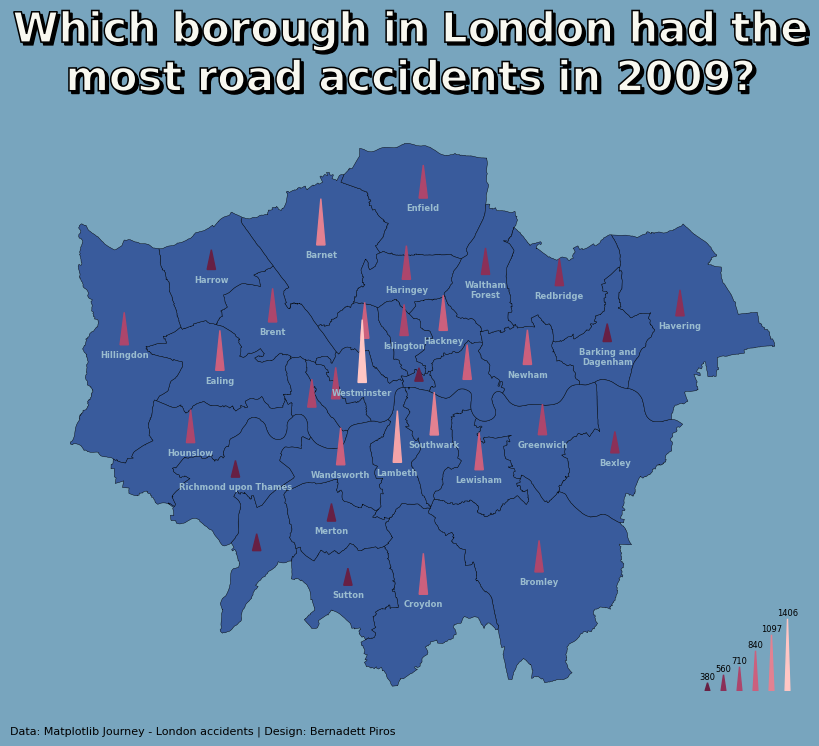

In [20]:
fig, ax = plt.subplots(figsize=(10, 8))

gdf.plot(ax=ax, color='#395B9C', lw=0.3, edgecolor='black')

for i, row in df_grouped.iterrows():
    x = row["centroid"].x
    y = row["centroid"].y      
    height = row["total_count"] / multiplier      
    
    triangle_color = create_triangle(ax, x, y, height=height, base=0.005, norm=norm, colormap=colormap)
    ax.set_facecolor("#78A5BE")    

    if row["name"] in boroughs_txt:
        ax.text(
            x,
            y - 0.004,
            row["name"],             
            color="#9abccf",
            fontsize=6,
            weight="bold",
            ha="center",
            va='top'            
        )       

    ax.axis("off")       

# Legend
inset_ax = fig.add_axes([0.65, 0.15, 0.375, 0.1]) 
inset_ax.set_xlim(0, 1.2)
inset_ax.set_ylim(0, 1)
inset_ax.set_aspect('equal')

# Create triangles 
create_triangle(inset_ax, 0.1, 0, height=0.1, base=0.03)
create_triangle(inset_ax, 0.3, 0, height=0.2, base=0.03)
create_triangle(inset_ax, 0.5, 0, height=0.3, base=0.03)
create_triangle(inset_ax, 0.7, 0, height=0.5, base=0.03)
create_triangle(inset_ax, 0.9, 0, height=0.7, base=0.03)
create_triangle(inset_ax, 1.1, 0, height=0.9, base=0.03)

# Add legend labels
inset_ax.text(0.1, 0.15, "380", size=6, ha="center")
inset_ax.text(0.3, 0.25, "560", size=6, ha="center")
inset_ax.text(0.5, 0.35, "710", size=6, ha="center")
inset_ax.text(0.7, 0.55, "840", size=6, ha="center")
inset_ax.text(0.9, 0.75, "1097", size=6, ha="center")
inset_ax.text(1.1, 0.95, "1406", size=6, ha="center")

inset_ax.axis("off")
inset_ax.set_facecolor("#78A5BE")
   
fig.set_facecolor("#78A5BE")

# Title
t = fig.text(0.5, 0.9, "Which borough in London had the\nmost road accidents in 2009?", color="white", size=30, weight="bold", ha="center")
t.set_path_effects([
    path_effects.PathPatchEffect(
        offset=(2, -2), facecolor='black'),
    path_effects.PathPatchEffect(
        edgecolor='black', linewidth=1.1, facecolor='#F8F8F0')])

fig.text(0.1, 0.1, "Data: Matplotlib Journey - London accidents | Design: Bernadett Piros", size=8, va="center")

plt.show()

#fig.savefig("Spike_map_continous.png", bbox_inches='tight', pad_inches=0.2)

/tmp/ipykernel_180373/1315334978.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["centroid"] = gdf.centroid


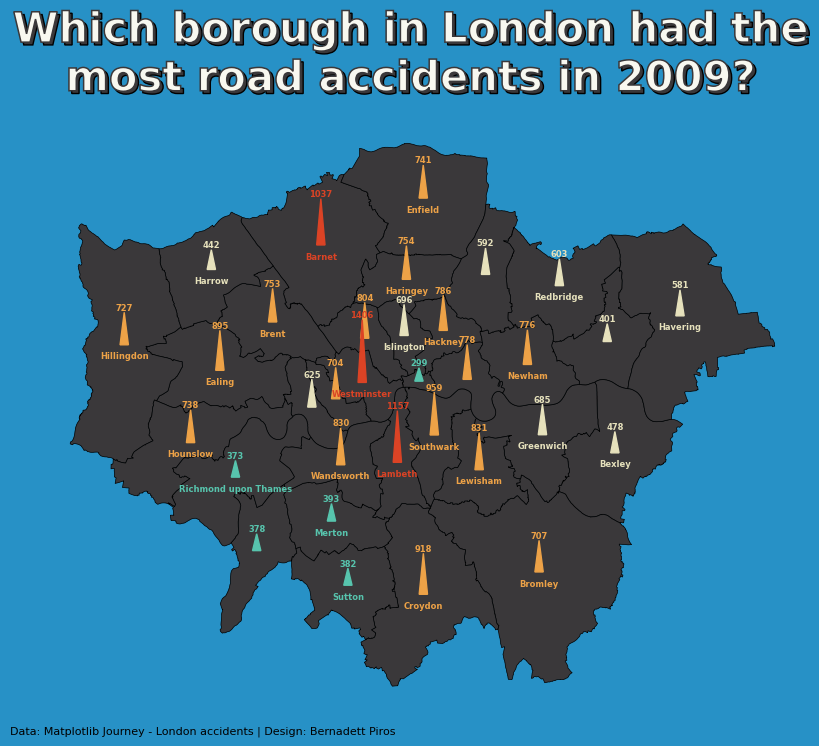

In [21]:
url = "https://raw.githubusercontent.com/JosephBARBIERDARNAL/data-matplotlib-journey/refs/heads/main/accident-london/accident-london.csv"
df = pd.read_csv(url)

url = "https://raw.githubusercontent.com/JosephBARBIERDARNAL/data-matplotlib-journey/refs/heads/main/london/london.geojson"
gdf = gpd.read_file(url)

gdf = gdf.set_index("name")
gdf["centroid"] = gdf.centroid

df_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs="EPSG:4326")
df_joined = gpd.sjoin(df_gdf, gdf)
df_grouped = df_joined.groupby("name")["id"].size().reset_index(name="total_count")
df_grouped= pd.merge(df_grouped, gdf, on="name")
df_grouped = gpd.GeoDataFrame(df_grouped, crs="EPSG:4326")

boroughs_text = df_grouped["name"].unique()

boroughs_txt = ['Barking and\nDagenham', 'Barnet', 'Bexley', 'Brent', 'Bromley', 'Croydon', 'Ealing', 'Enfield',
                'Greenwich', 'Hackney', 'Haringey', 'Harrow', 'Havering', 'Hillingdon', 'Hounslow', 'Islington',
                'Kingston\nupon\nThames', 'Lambeth', 'Lewisham', 'Merton', 'Newham', 'Redbridge', 'Richmond upon Thames',
                'Southwark', 'Sutton', 'Tower\nHamlets', 'Waltham\nForest', 'Wandsworth', 'Westminster']

def create_triangle(x, y, height, base, threshold1, threshold2, threshold3):
    
    if height <= threshold1:
        color = '#57C4AD'  
    elif height <= threshold2:
        color = '#E6E1BC'  
    elif height <= threshold3:
        color = '#EDA247'  
    else:
        color = '#DB4325'      
    
    triangle = mpatches.Polygon(
        [[x - base, y], [x, y + height], [x + base, y]],
        color=color,
        fill=True
    )
    
    return triangle, color  
    
fig, ax = plt.subplots(figsize=(10, 8))

gdf.plot(ax=ax, color='#3A383A', lw=0.5, edgecolor='black')

multiplier = 30000

threshold1 = 400 / multiplier
threshold2 = 700 / multiplier
threshold3 = 1000 / multiplier

for i, row in df_grouped.iterrows():
    x = row["centroid"].x
    y = row["centroid"].y
    height = row.total_count / multiplier      
    
    triangle, color = create_triangle(x, y, height, base=0.005, threshold1=threshold1, threshold2=threshold2, threshold3=threshold3) 

    ax.add_patch(triangle)       

    ax.set_facecolor("#2791C6")

    if row["name"] in boroughs_txt:
        ax.text(
            x,
            y - 0.005,
            row["name"],
            color=color,
            fontsize=6,
            weight="bold",
            ha="center",
            va='top'  
        )

    if row["name"] in boroughs_text:
        ax.text(
            x,            
            y + height +0.007,
            row["total_count"],
            color=color,
            fontsize=6,
            weight="bold",
            ha="center",
            va='top'  
        )

fig.set_facecolor("#2791C6")

t = fig.text(0.5, 0.9, "Which borough in London had the\nmost road accidents in 2009?", color="white", size=30, weight="bold", ha="center")
t.set_path_effects([
    path_effects.PathPatchEffect(
        offset=(2, -2), facecolor='#3A383A'),
    path_effects.PathPatchEffect(
        edgecolor='#3A383A', linewidth=1.1, facecolor='#F8F8F0')])

ax.axis("off")

fig.text(0.1, 0.1, "Data: Matplotlib Journey - London accidents | Design: Bernadett Piros", size=8, va="center")

#plt.show()

fig.savefig("Spike_map_dicrete.png", bbox_inches='tight', pad_inches=0.2)